## Описание проекта

Это учебный проект Яндекс.Практикума по маркетинговой и бизнес-аналитике.

"Вас пригласили на стажировку в отдел маркетинговой аналитики Яндекс.Афиши. Первое задание: помочь маркетологам снизить расходы — отказаться от невыгодных источников трафика и перераспределить бюджет.

Есть данные Яндекс.Афиши с июня 2017 по конец мая 2018 года:
* 		лог сервера с данными о посещениях сайта Яндекс.Афиши,
* 		выгрузка всех заказов за этот период,
* 		статистика рекламных расходов.

Вам предстоит изучить:
* 		как клиенты пользуются сервисом,
* 		когда делают первые покупки на сайте,
* 		сколько денег приносит компании каждый клиент,
* 		когда расходы на привлечение клиента окупаются.

Выручка измеряется в условных единицах — у.е."



## Описание данных

"В вашем распоряжении три датасета.

Файл visits_log.csv хранит лог сервера с информацией о посещениях сайта, orders_log.csv — информацию о заказах, а costs.csv — информацию о расходах на маркетинг.

Структура visits_log.csv
* 		Uid — уникальный идентификатор пользователя,
* 		Device — категория устройства пользователя,
* 		Start Ts — дата и время начала сессии,
* 		End Ts — дата и время окончания сессии,
* 		Source Id — идентификатор источника перехода на сайт.

Структура orders_log.csv
* 		Uid — уникальный идентификатор пользователя,
* 		Buy Ts — дата и время заказа,
* 		Revenue — сумма заказа.

Структура costs.csv
* 		source_id — идентификатор рекламного источника,
* 		dt — дата проведения рекламной кампании,
* 		costs — расходы на эту кампанию."

## Первый взгляд на данные и предобработка

In [ ]:
import pandas as pd
from scipy import stats
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from dateutil import relativedelta

In [ ]:
visits = pd.read_csv('/datasets/visits_log.csv')
orders = pd.read_csv('/datasets/orders_log.csv')
costs = pd.read_csv('/datasets/costs.csv')

In [ ]:
visits.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 359400 entries, 0 to 359399
Data columns (total 5 columns):
Device       359400 non-null object
End Ts       359400 non-null object
Source Id    359400 non-null int64
Start Ts     359400 non-null object
Uid          359400 non-null uint64
dtypes: int64(1), object(3), uint64(1)
memory usage: 13.7+ MB


Пропущенных значений нет. Есть два столбца с датами, которые нужно перевести в формат datetime: End Ts и Start Ts

In [ ]:
visits = visits.rename(columns={'End Ts': 'end_ts', 'Source Id': 'source_id', 'Start Ts': 'start_ts', 'Uid': 'uid', 'Device': 'device'})
visits['end_ts'] = pd.to_datetime(visits['end_ts'])
visits['start_ts'] = pd.to_datetime(visits['start_ts'])
visits.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 359400 entries, 0 to 359399
Data columns (total 5 columns):
device       359400 non-null object
end_ts       359400 non-null datetime64[ns]
source_id    359400 non-null int64
start_ts     359400 non-null datetime64[ns]
uid          359400 non-null uint64
dtypes: datetime64[ns](2), int64(1), object(1), uint64(1)
memory usage: 13.7+ MB


Привели все имена столбцов к нижнему регистру, поменяли столбцы end_ts и start_ts на формат datetime.

In [ ]:
visits.sample(5)

,device,end_ts,source_id,start_ts,uid
127890,touch,2018-03-27 11:13:00,5,2018-03-27 11:11:00,6926847608302023124
285115,desktop,2017-09-04 21:04:00,3,2017-09-04 20:48:00,15112317130781620156
6030,desktop,2017-12-19 10:57:00,3,2017-12-19 10:56:00,2147318234969175165
321581,desktop,2018-01-21 21:16:00,5,2018-01-21 21:14:00,15041165347281357704
239711,desktop,2018-02-16 12:23:00,5,2018-02-16 12:16:00,18395455022705133354


In [ ]:
visits.duplicated().sum()

0

Дубликатов в датафрейме visits не обнаружено.

In [ ]:
orders.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50415 entries, 0 to 50414
Data columns (total 3 columns):
Buy Ts     50415 non-null object
Revenue    50415 non-null float64
Uid        50415 non-null uint64
dtypes: float64(1), object(1), uint64(1)
memory usage: 1.2+ MB


В датафрейме orders нет пропущенных значений, переведем столбец Buy Ts в формат datetime.

In [ ]:
orders = orders.rename(columns={'Buy Ts': 'buy_ts', 'Revenue': 'revenue', 'Uid': 'uid'})
orders['buy_ts'] = pd.to_datetime(orders['buy_ts'])
orders.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50415 entries, 0 to 50414
Data columns (total 3 columns):
buy_ts     50415 non-null datetime64[ns]
revenue    50415 non-null float64
uid        50415 non-null uint64
dtypes: datetime64[ns](1), float64(1), uint64(1)
memory usage: 1.2 MB


In [ ]:
orders.sample(5)

,buy_ts,revenue,uid
42452,2018-03-27 19:40:00,1.33,14047596167133747821
40682,2018-03-19 21:09:00,0.06,2051637132803741960
43113,2018-04-04 21:35:00,1.65,14606040286849988498
2492,2017-07-03 16:42:00,1.47,9970429426443765620
19461,2017-11-24 17:33:00,22.73,11947550432093591251


In [ ]:
orders.duplicated().sum()

0

В датафрейме orders не обнаружено пропущенных значений, столбец buy_ts перевели в формат datetime.

In [ ]:
costs.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2542 entries, 0 to 2541
Data columns (total 3 columns):
source_id    2542 non-null int64
dt           2542 non-null object
costs        2542 non-null float64
dtypes: float64(1), int64(1), object(1)
memory usage: 59.7+ KB


In [ ]:
costs['dt'] = pd.to_datetime(costs['dt'])
costs.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2542 entries, 0 to 2541
Data columns (total 3 columns):
source_id    2542 non-null int64
dt           2542 non-null datetime64[ns]
costs        2542 non-null float64
dtypes: datetime64[ns](1), float64(1), int64(1)
memory usage: 59.7 KB


In [ ]:
costs.sample(5)

,source_id,dt,costs
2425,10,2018-02-02,12.19
2460,10,2018-03-09,28.27
911,3,2017-12-03,404.96
804,3,2017-08-18,242.57
233,1,2018-01-20,50.77


В датафрейме costs поменяли столбец dt на формат datetime, пропущенных значений не нашли.

## Продуктовые метрики

### Рассчитаем DAU, WAU и MAU


In [ ]:
visits.head()

,device,end_ts,source_id,start_ts,uid
0,touch,2017-12-20 17:38:00,4,2017-12-20 17:20:00,16879256277535980062
1,desktop,2018-02-19 17:21:00,2,2018-02-19 16:53:00,104060357244891740
2,touch,2017-07-01 01:54:00,5,2017-07-01 01:54:00,7459035603376831527
3,desktop,2018-05-20 11:23:00,9,2018-05-20 10:59:00,16174680259334210214
4,desktop,2017-12-27 14:06:00,3,2017-12-27 14:06:00,9969694820036681168


In [ ]:
visits['session_year'] = visits['start_ts'].dt.year
visits['session_month'] = visits['start_ts'].astype('datetime64[M]')
visits['session_week'] = visits['start_ts'].astype('datetime64[W]')
visits['session_date'] = visits['start_ts'].dt.date
visits.head()

,device,end_ts,source_id,start_ts,uid,session_year,session_month,session_week,session_date
0,touch,2017-12-20 17:38:00,4,2017-12-20 17:20:00,16879256277535980062,2017,2017-12-01,2017-12-14,2017-12-20
1,desktop,2018-02-19 17:21:00,2,2018-02-19 16:53:00,104060357244891740,2018,2018-02-01,2018-02-15,2018-02-19
2,touch,2017-07-01 01:54:00,5,2017-07-01 01:54:00,7459035603376831527,2017,2017-07-01,2017-06-29,2017-07-01
3,desktop,2018-05-20 11:23:00,9,2018-05-20 10:59:00,16174680259334210214,2018,2018-05-01,2018-05-17,2018-05-20
4,desktop,2017-12-27 14:06:00,3,2017-12-27 14:06:00,9969694820036681168,2017,2017-12-01,2017-12-21,2017-12-27


Добавили столбцы session_year, session_month, session_week, session_date, чтобы высчитать DAU, WAU и MAU.

In [ ]:
dau_total = visits.groupby('session_date').agg({'uid': 'nunique'}).median()
dau_total

uid    921.0
dtype: float64

Средний DAU за все время равняется 921 уникальному пользователю, то есть в среднем за все время в день на Яндекс.Афишу заходило 921 уникальных пользователей.

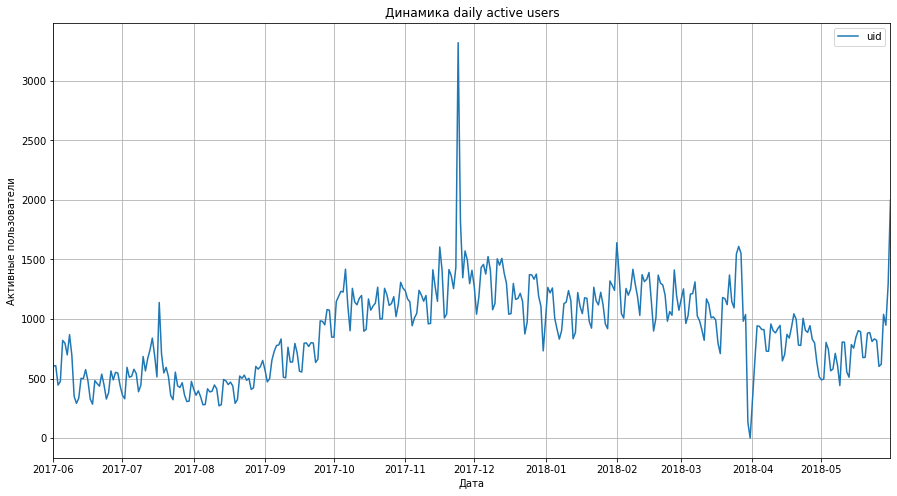

In [ ]:
visits.groupby('session_date').agg({'uid': 'nunique'}).plot(figsize=(15,8), grid=True)
plt.title('Динамика daily active users')
plt.xlabel('Дата')
plt.ylabel('Активные пользователи')
plt.show()

Как видим по графику - всплеск активности пользователей наблюдался в конце ноября.

In [ ]:
wau_total = visits.groupby('session_week').agg({'uid': 'nunique'}).median()
wau_total

uid    5894.0
dtype: float64

Средний WAU за все время равняется 5894 уникальным пользователям, то есть в среднем за все время в неделю на Яндекс.Афишу заходило 5894 уникальных пользователя.

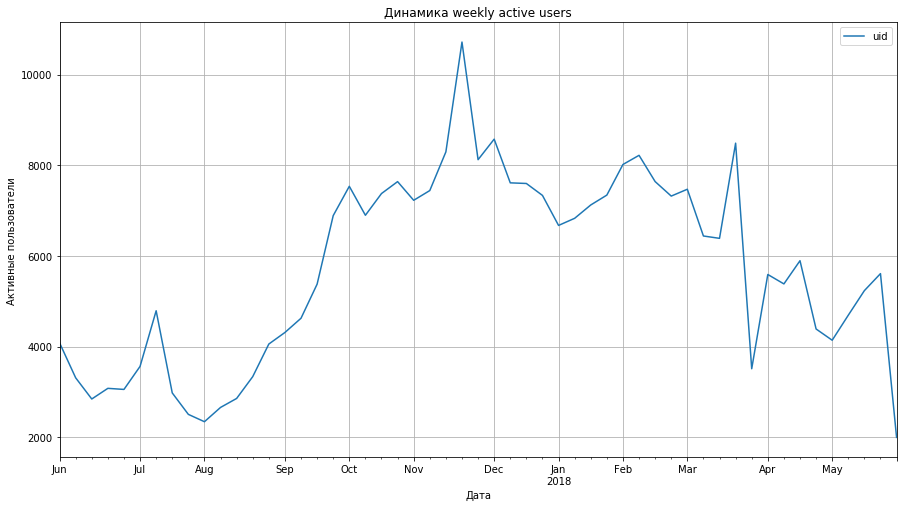

In [ ]:
visits.groupby('session_week').agg({'uid': 'nunique'}).plot(figsize=(15,8), grid=True)
plt.title('Динамика weekly active users')
plt.xlabel('Дата')
plt.ylabel('Активные пользователи')
plt.show()

Как видно по графику, период с октября по март - "высокий сезон" по WAU c пиком в конце ноября.

In [ ]:
mau_total = visits.groupby('session_month').agg({'uid': 'nunique'}).median()
mau_total

uid    24240.5
dtype: float64

Средний MAU за все время равняется 24240 уникальным пользователям.

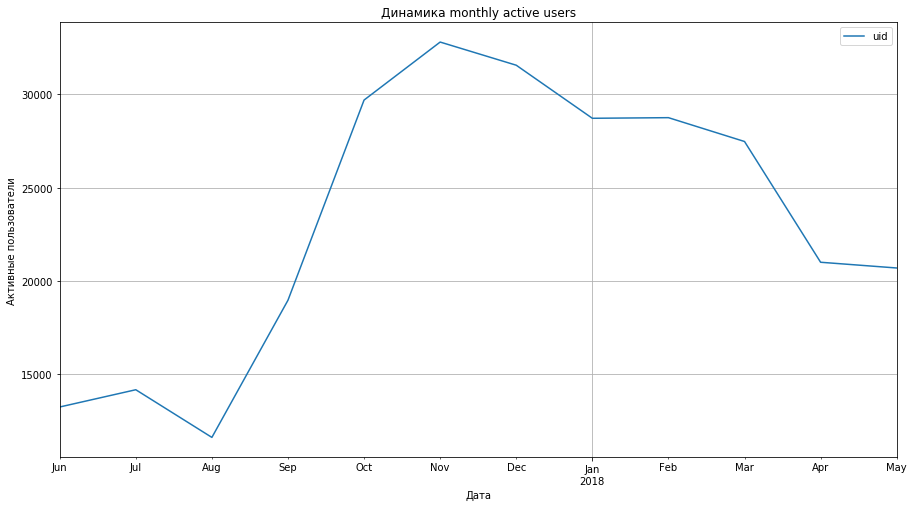

In [ ]:
visits.groupby('session_month').agg({'uid': 'nunique'}).plot(figsize=(15,8), grid=True)
plt.title('Динамика monthly active users')
plt.xlabel('Дата')
plt.ylabel('Активные пользователи')
plt.show()

По динамике MAU такие же выводы, как и по динамике WAU: рост начинается с сентября, пиковые значения: с октября по март.

### Определим, сколько раз за день пользователи в среднем заходят на сайт

In [ ]:
visits_per_user = visits.groupby('session_date').agg({'uid': 'count'}) / visits.groupby('session_date').agg({'uid': 'nunique'})
(visits_per_user).mean()

uid    1.08217
dtype: float64

В среднем пользователь заходит на сайт один раз.

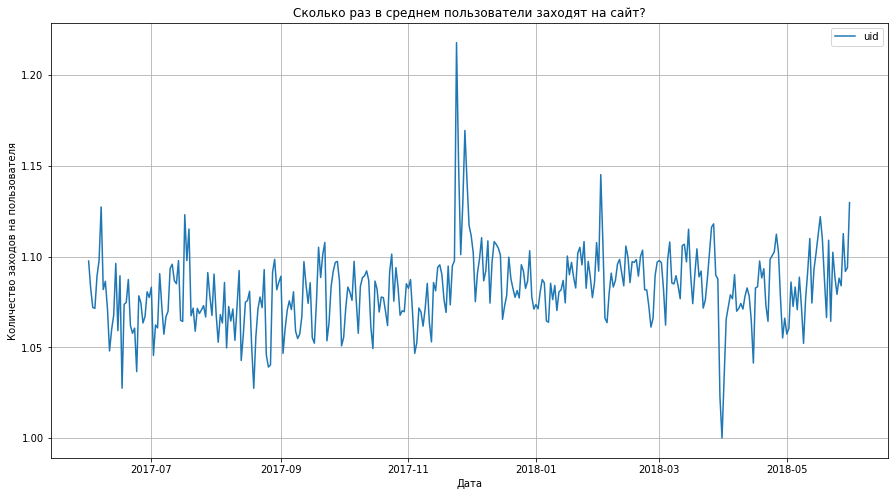

In [ ]:
visits_per_user.plot(figsize=(15,8), grid=True)
plt.title('Сколько раз в среднем пользователи заходят на сайт?')
plt.xlabel('Дата')
plt.ylabel('Количество заходов на пользователя')
plt.show()

Динамика средних заходов пользователя примерно такая же, как и динамика DAU.

### Исследуем, сколько времени пользователи проводят на сайте

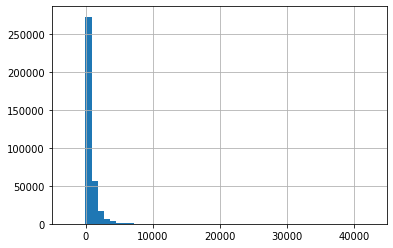

In [ ]:
visits['session_duration'] = visits['end_ts'] - visits['start_ts']
visits['session_duration'] = visits['session_duration'].dt.total_seconds()
visits['session_duration'].hist(bins=50);

Добавили колонку session_duration. Распределение у времени сессии экспоненциальное, поэтому для среднего выберем медиану.

In [ ]:
visits['session_duration'].describe()

count    359400.000000
mean        643.025687
std         997.127761
min       -2760.000000
25%         120.000000
50%         300.000000
75%         840.000000
max       42660.000000
Name: session_duration, dtype: float64

В среднем пользователи проводят 300 секунд на сайте, то есть около 5 минут. Минимальное значение отрицательное, минус 2760 секунд. Посмотрим, много ли таких значений.

In [ ]:
visits[visits['session_duration'] < 0]

,device,end_ts,source_id,start_ts,uid,session_year,session_month,session_week,session_date,session_duration
4181,desktop,2018-03-25 03:18:00,3,2018-03-25 03:50:00,13092152539246794986,2018,2018-03-01,2018-03-22,2018-03-25,-1920.0
177972,desktop,2018-03-25 03:09:00,9,2018-03-25 03:55:00,4621202742905035453,2018,2018-03-01,2018-03-22,2018-03-25,-2760.0


Отрицательных значений в колонке session_duration всего 2, они не повлияют на результат. Нужно узнать у разработчиков, откуда они взялись.

### Рассчитаем Retention Rate

In [ ]:
first_activity_month = visits.groupby(['uid'])['session_date'].min().astype('datetime64[M]')
first_activity_month.name = 'first_activity_month'
first_activity_month

uid
11863502262781         2018-03-01
49537067089222         2018-02-01
297729379853735        2017-06-01
313578113262317        2017-09-01
325320750514679        2017-09-01
                          ...    
18446403737806311543   2017-11-01
18446424184725333426   2017-12-01
18446556406699109058   2018-01-01
18446621818809592527   2017-12-01
18446676030785672386   2017-10-01
Name: first_activity_month, Length: 228169, dtype: datetime64[ns]

Для каждого пользователя нашли месяц, когда он впервые зашел на сайт.

In [ ]:
user_activity = visits[['uid', 'session_month', 'session_date']].join(first_activity_month, on='uid')
user_activity.head()

,uid,session_month,session_date,first_activity_month
0,16879256277535980062,2017-12-01,2017-12-20,2017-12-01
1,104060357244891740,2018-02-01,2018-02-19,2018-02-01
2,7459035603376831527,2017-07-01,2017-07-01,2017-07-01
3,16174680259334210214,2018-05-01,2018-05-20,2018-03-01
4,9969694820036681168,2017-12-01,2017-12-27,2017-12-01


Взяли нужны столбцы из датафрейма visits и добавили к ним first_activity_month

In [ ]:
user_activity['cohort_lifetime'] = (user_activity['session_month'] - user_activity['first_activity_month'])
user_activity['cohort_lifetime'] = user_activity['cohort_lifetime'] / np.timedelta64(1, 'M')
user_activity['cohort_lifetime'] = user_activity['cohort_lifetime'].round().astype('int')
user_activity

,uid,session_month,session_date,first_activity_month,cohort_lifetime
0,16879256277535980062,2017-12-01,2017-12-20,2017-12-01,0
1,104060357244891740,2018-02-01,2018-02-19,2018-02-01,0
2,7459035603376831527,2017-07-01,2017-07-01,2017-07-01,0
3,16174680259334210214,2018-05-01,2018-05-20,2018-03-01,2
4,9969694820036681168,2017-12-01,2017-12-27,2017-12-01,0
...,...,...,...,...,...
359395,18363291481961487539,2017-07-01,2017-07-29,2017-07-01,0
359396,18370831553019119586,2018-01-01,2018-01-25,2018-01-01,0
359397,18387297585500748294,2018-03-01,2018-03-03,2018-03-01,0
359398,18388616944624776485,2017-11-01,2017-11-02,2017-11-01,0


Если first_activity_month показывает нам, к какой когорте принадлежит пользователь, то cohort_lifetime показывает, сколько месяцев прошло с первой активности пользователя.

In [ ]:
cohorts = user_activity.groupby(['first_activity_month','cohort_lifetime']).agg({'uid':'nunique'}).reset_index()
cohorts

,first_activity_month,cohort_lifetime,uid
0,2017-06-01,0,13259
1,2017-06-01,1,1043
2,2017-06-01,2,713
3,2017-06-01,3,814
4,2017-06-01,4,909
...,...,...,...
73,2018-03-01,1,861
74,2018-03-01,2,557
75,2018-04-01,0,15709
76,2018-04-01,1,760


В cohorts сохранили количество заходов пользователей по когортам и месяцу когорты.

In [ ]:
initial_users_count = cohorts[cohorts['cohort_lifetime'] == 0][
    ['first_activity_month', 'uid']
]
initial_users_count = initial_users_count.rename(columns={'uid':'cohort_users'}) 
initial_users_count

,first_activity_month,cohort_users
0,2017-06-01,13259
12,2017-07-01,13140
23,2017-08-01,10181
33,2017-09-01,16704
42,2017-10-01,25977
50,2017-11-01,27248
57,2017-12-01,25268
63,2018-01-01,22624
68,2018-02-01,22197
72,2018-03-01,20589


Для каждой когорты посчитали количество пользователей в ней.

In [ ]:
cohorts = cohorts.merge(initial_users_count,on='first_activity_month')
cohorts

,first_activity_month,cohort_lifetime,uid,cohort_users
0,2017-06-01,0,13259,13259
1,2017-06-01,1,1043,13259
2,2017-06-01,2,713,13259
3,2017-06-01,3,814,13259
4,2017-06-01,4,909,13259
...,...,...,...,...
73,2018-03-01,1,861,20589
74,2018-03-01,2,557,20589
75,2018-04-01,0,15709,15709
76,2018-04-01,1,760,15709


Теперь в таблице cohorts у нас есть все данные для того, чтобы рассчитать Retention Rate: нужно лишь разделить количество уникальных пользователей в определенной cohort_lifetime на общее количество пользователей в когорте.

In [ ]:
cohorts['retention'] = cohorts['uid']/cohorts['cohort_users'] 
cohorts

,first_activity_month,cohort_lifetime,uid,cohort_users,retention
0,2017-06-01,0,13259,13259,1.000000
1,2017-06-01,1,1043,13259,0.078664
2,2017-06-01,2,713,13259,0.053775
3,2017-06-01,3,814,13259,0.061392
4,2017-06-01,4,909,13259,0.068557
...,...,...,...,...,...
73,2018-03-01,1,861,20589,0.041818
74,2018-03-01,2,557,20589,0.027053
75,2018-04-01,0,15709,15709,1.000000
76,2018-04-01,1,760,15709,0.048380


Таблица готова, теперь сделаем пивотник и хитмэп, чтобы наглядно продемонстрировать динамику Retention Rate по когортам.

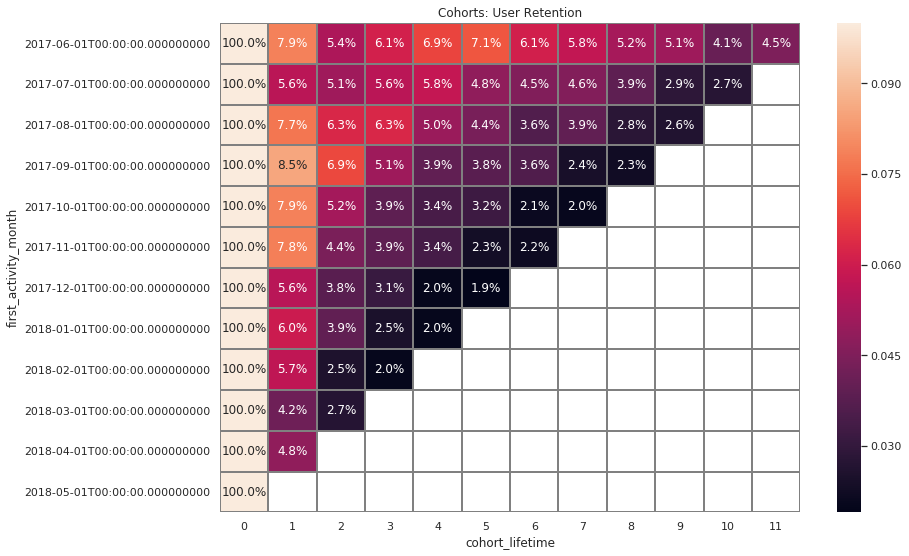

In [ ]:
retention_pivot = cohorts.pivot_table(
    index='first_activity_month',
    columns='cohort_lifetime',
    values='retention',
    aggfunc='sum',
)

sns.set(style='white')
plt.figure(figsize=(13, 9))
plt.title('Cohorts: User Retention')
sns.heatmap(retention_pivot, annot=True, fmt='.1%', linewidths=1, linecolor='gray', vmax=0.1);

Retention Rate колеблется в районе 2-5%. Нельзя сказать, что он постоянно снижается: часто retention выше на более поздних месяцах. 

In [ ]:
cohorts[cohorts['cohort_lifetime'] == 2]['retention'].median()

0.05176613910127382

Средний Retention Rate равен 5%.

### Выводы:

* В среднем пользователи проводят около 5 минут на сайте

* Средний DAU за все время равняется 921 уникальному пользователю

* Средний WAU за все время равняется 5894 уникальным пользователям

* Средний MAU за все время равняется 24240 уникальным пользователям

* Чаще всего на сайт заходят с октября по март, пиковые значения пользовательской активности приходятся на конец ноября

* В среднем пользователи, которые зашли на сайт, в тот же день больше на него не возвращаются (среднее арифметическое - 1.08 заходов в день)

* Средний Retention Rate равен 5%.

* Retention Rate колеблется в районе 2-5%. Нельзя сказать, что он постоянно снижается: часто retention выше на более поздних месяцах жизни когорты. 

## Метрики электронной коммерции

### Cколько времени в среднем проходит с момента первого посещения сайта до совершения покупки?

In [ ]:
first_session = visits.groupby(['uid'])['start_ts'].min()
first_session.name = 'first_session'
first_session

uid
11863502262781         2018-03-01 17:27:00
49537067089222         2018-02-06 15:55:00
297729379853735        2017-06-07 18:47:00
313578113262317        2017-09-18 22:49:00
325320750514679        2017-09-30 14:29:00
                               ...        
18446403737806311543   2017-11-30 03:36:00
18446424184725333426   2017-12-06 20:32:00
18446556406699109058   2018-01-01 16:29:00
18446621818809592527   2017-12-27 13:27:00
18446676030785672386   2017-10-04 16:01:00
Name: first_session, Length: 228169, dtype: datetime64[ns]

Получили табличку, где каждому пользователю сопоставлена дата первого захода на сайт.

In [ ]:
first_order = orders.groupby('uid')['buy_ts'].min()
first_order.name = 'first_order'
first_order

uid
313578113262317        2018-01-03 21:51:00
1575281904278712       2017-06-03 10:13:00
2429014661409475       2017-10-11 18:33:00
2464366381792757       2018-01-28 15:54:00
2551852515556206       2017-11-24 10:14:00
                               ...        
18445147675727495770   2017-11-24 09:03:00
18445407535914413204   2017-09-22 23:55:00
18445601152732270159   2018-03-26 22:54:00
18446156210226471712   2018-02-18 19:34:00
18446167067214817906   2017-10-17 10:16:00
Name: first_order, Length: 36523, dtype: datetime64[ns]

Каждому пользователю присвоили дату первой покупки на сайте.

In [ ]:
first_session_order = pd.merge(left=first_order, right=first_session, how='inner', on='uid')
first_session_order.describe()

,first_order,first_session
count,36523,36523
unique,34122,34364
top,2017-11-24 17:42:00,2018-05-31 10:03:00
freq,7,7
first,2017-06-01 00:10:00,2017-06-01 00:09:00
last,2018-06-01 00:02:00,2018-05-31 23:59:00


В first_session_order каждому пользователю сопоставили дату первого захода на сайт и дату первой покупки.

In [ ]:
time_to_first_order = first_session_order['first_order'] - first_session_order['first_session']
time_to_first_order.describe()

count                      36523
mean     16 days 21:40:10.550064
std      47 days 01:44:46.481416
min              0 days 00:00:00
25%              0 days 00:04:00
50%              0 days 00:16:00
75%              2 days 00:17:00
max            363 days 07:04:00
dtype: object

Медианное время покупки - 16 минут. По всей видимости, пользователи в основном совершают покупки в первый же заход. Если не купил сразу - видимо, не купит и после.

###  Рассчитаем среднее количество покупок на одного покупателя за 6 месяцев

In [ ]:
orders_last_6_months = orders[orders['buy_ts'] > orders['buy_ts'].max() - relativedelta.relativedelta(months=6)]

Получили датафрейм с заказами за последние 6 месяцев с даты последнего заказа.

In [ ]:
orders_last_6_months['buy_ts'].count() / orders_last_6_months['uid'].nunique()

1.3363573883161513

В среднем один покупатель делал 1.34 заказа.

### Рассчитаем средний чек

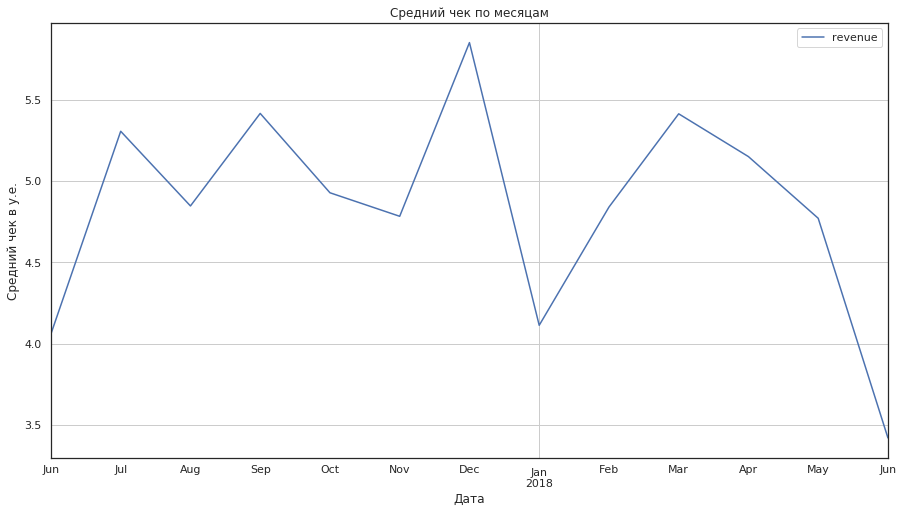

In [ ]:
average_check = orders.copy()
average_check['date'] = average_check['buy_ts'].astype('datetime64[M]')
average_check.groupby('date').agg({'revenue': 'mean'}).plot(figsize=(15,8), grid=True)
plt.title('Средний чек по месяцам')
plt.xlabel('Дата')
plt.ylabel('Средний чек в у.е.')
plt.show()

Мы видим пики значений средних чеков в июле, сентябре, декабре 2017 и марте 2018.

In [ ]:
average_check['revenue'].mean()

4.999646930477041

Средний чек равен 5 у.е.

### Рассчитаем LTV на покупателя по когортам

In [ ]:
ltv_orders = orders.copy()
ltv_orders['order_month'] = ltv_orders['buy_ts'].astype('datetime64[M]')
ltv_first_orders = ltv_orders.groupby('uid').agg({'order_month': 'min'}).reset_index()
ltv_first_orders.columns = ['uid', 'first_order_month']
ltv_first_orders.head()

,uid,first_order_month
0,313578113262317,2018-01-01
1,1575281904278712,2017-06-01
2,2429014661409475,2017-10-01
3,2464366381792757,2018-01-01
4,2551852515556206,2017-11-01


Для каждого пользователя получили месяц, когда он сделал первый заказ.

In [ ]:
cohort_sizes = (
    ltv_first_orders.groupby('first_order_month')
    .agg({'uid': 'nunique'})
    .reset_index()
)
cohort_sizes.columns = ['first_order_month', 'n_buyers']
cohort_sizes.head()

,first_order_month,n_buyers
0,2017-06-01,2023
1,2017-07-01,1923
2,2017-08-01,1370
3,2017-09-01,2581
4,2017-10-01,4340


Сделали таблицу, где посчитаны размеры когорты - количество уникальных пользователей, которые совершили покупку в тот или иной месяц.

In [ ]:
ltv_orders = pd.merge(ltv_orders, ltv_first_orders, on='uid')
ltv_orders

,buy_ts,revenue,uid,order_month,first_order_month
0,2017-06-01 00:10:00,17.00,10329302124590727494,2017-06-01,2017-06-01
1,2017-06-01 00:25:00,0.55,11627257723692907447,2017-06-01,2017-06-01
2,2017-06-01 00:27:00,0.37,17903680561304213844,2017-06-01,2017-06-01
3,2017-06-01 00:29:00,0.55,16109239769442553005,2017-06-01,2017-06-01
4,2017-06-01 07:58:00,0.37,14200605875248379450,2017-06-01,2017-06-01
...,...,...,...,...,...
50410,2018-05-31 23:50:00,4.64,12296626599487328624,2018-05-01,2018-05-01
50411,2018-05-31 23:50:00,5.80,11369640365507475976,2018-05-01,2018-05-01
50412,2018-05-31 23:54:00,0.30,1786462140797698849,2018-05-01,2018-05-01
50413,2018-05-31 23:56:00,3.67,3993697860786194247,2018-05-01,2018-05-01


Для каждого заказа добавили идентификатор когорты.

In [ ]:
cohorts = (
    ltv_orders.groupby(['first_order_month', 'order_month'])
    .agg({'revenue': 'sum'})
    .reset_index()
)
cohorts.head()

,first_order_month,order_month,revenue
0,2017-06-01,2017-06-01,9557.49
1,2017-06-01,2017-07-01,981.82
2,2017-06-01,2017-08-01,885.34
3,2017-06-01,2017-09-01,1931.30
4,2017-06-01,2017-10-01,2068.58


Рассчитали суммарную выручку для каждой когорты по месяцам.

In [ ]:
ltv_report = pd.merge(cohort_sizes, cohorts, on='first_order_month')
ltv_report

,first_order_month,n_buyers,order_month,revenue
0,2017-06-01,2023,2017-06-01,9557.49
1,2017-06-01,2023,2017-07-01,981.82
2,2017-06-01,2023,2017-08-01,885.34
3,2017-06-01,2023,2017-09-01,1931.30
4,2017-06-01,2023,2017-10-01,2068.58
...,...,...,...,...
74,2018-03-01,3533,2018-05-01,1114.87
75,2018-04-01,2276,2018-04-01,10600.69
76,2018-04-01,2276,2018-05-01,1209.92
77,2018-05-01,2988,2018-05-01,13925.76


Добавили в таблицу количество покупателей для каждой когорты.

In [ ]:
margin_rate = 1.0

ltv_report['gp'] = ltv_report['revenue'] * margin_rate
ltv_report['age'] = (
    ltv_report['order_month'] - ltv_report['first_order_month']
) / np.timedelta64(1, 'M')
ltv_report['age'] = ltv_report['age'].round().astype('int')
ltv_report

,first_order_month,n_buyers,order_month,revenue,gp,age
0,2017-06-01,2023,2017-06-01,9557.49,9557.49,0
1,2017-06-01,2023,2017-07-01,981.82,981.82,1
2,2017-06-01,2023,2017-08-01,885.34,885.34,2
3,2017-06-01,2023,2017-09-01,1931.30,1931.30,3
4,2017-06-01,2023,2017-10-01,2068.58,2068.58,4
...,...,...,...,...,...,...
74,2018-03-01,3533,2018-05-01,1114.87,1114.87,2
75,2018-04-01,2276,2018-04-01,10600.69,10600.69,0
76,2018-04-01,2276,2018-05-01,1209.92,1209.92,1
77,2018-05-01,2988,2018-05-01,13925.76,13925.76,0


Маржинальность по условию задачи равна 100%, поэтому валовая прибыль равна выручке.

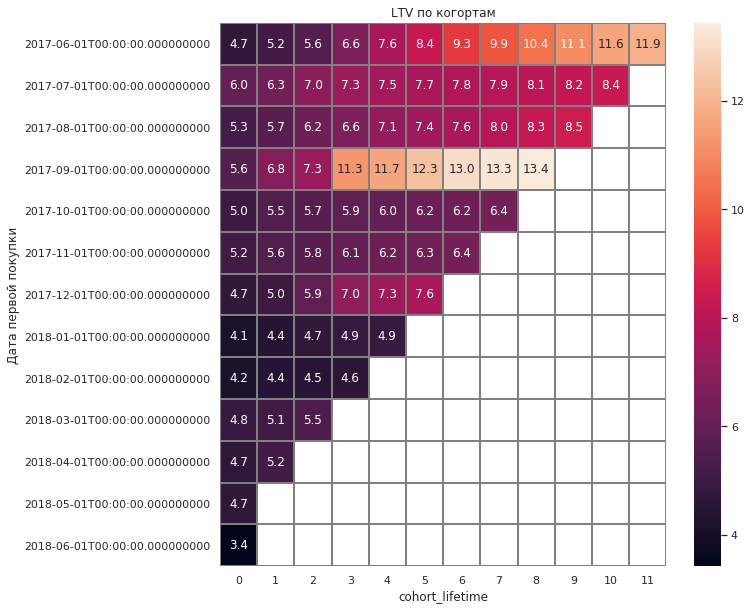

In [ ]:
ltv_report['ltv'] = ltv_report['gp'] / ltv_report['n_buyers']



output = ltv_report.pivot_table(
    index='first_order_month', columns='age', values='ltv', aggfunc='mean'
)

fig, ax = plt.subplots(figsize=(10,10))

sns.heatmap(output.cumsum(axis=1), 
                    annot=True, fmt='.1f', linewidths=1, linecolor='gray', ax=ax)

plt.title(f'LTV по когортам')
plt.xlabel('cohort_lifetime')
plt.ylabel('Дата первой покупки')
plt.show()

Самый высокая динамика LTV у июньской и сентябрьской.

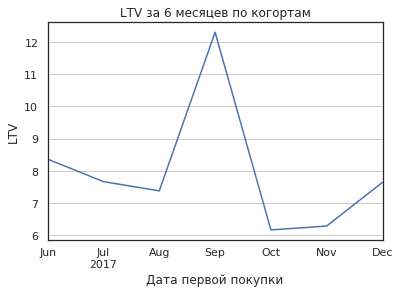

In [ ]:
output.cumsum(axis=1).iloc[0:7, 5].plot(grid=True)
plt.title('LTV за 6 месяцев по когортам')
plt.xlabel('Дата первой покупки')
plt.ylabel('LTV')
plt.show()

В сентябре 2017-го года самый высокий LTV за 6 месяцев по когортам.

In [ ]:
output.cumsum(axis=1).iloc[0:7, 5].mean()

7.969052630207336

Средний LTV за 6 месяцев по когортам равен 7.9 у.е.

### Выводы:

* Самый высокая динамика LTV у июньской и сентябрьской когорт.
* Средний LTV за 6 месяцев по когортам равен 7.9 у.е.
* В сентябре 2017-го года самый высокий LTV за 6 месяцев по когортам -  12.3 у. е.

## Маркетинговые метрики

In [ ]:
costs

,source_id,dt,costs
0,1,2017-06-01,75.20
1,1,2017-06-02,62.25
2,1,2017-06-03,36.53
3,1,2017-06-04,55.00
4,1,2017-06-05,57.08
...,...,...,...
2537,10,2018-05-27,9.92
2538,10,2018-05-28,21.26
2539,10,2018-05-29,11.32
2540,10,2018-05-30,33.15


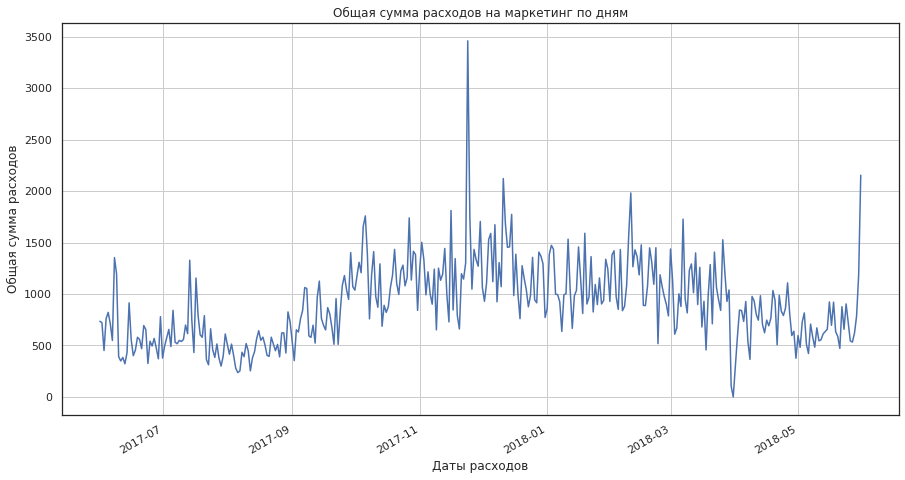

In [ ]:
costs.groupby('dt')['costs'].sum().plot(figsize=(15,8), grid=True)
plt.title('Общая сумма расходов на маркетинг по дням')
plt.xlabel('Даты расходов')
plt.ylabel('Общая сумма расходов')
plt.show()

График маркетинговых расходов по дням похож на график DAU.

In [ ]:
costs['costs'].sum()

329131.62

Суммарные расходы на маркетинг - 329131 у.е.

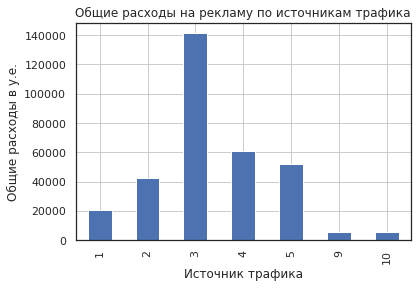

In [ ]:
costs.groupby('source_id')['costs'].sum().plot(kind='bar', grid=True)
plt.title('Общие расходы на рекламу по источникам трафика')
plt.xlabel('Источник трафика')
plt.ylabel('Общие расходы в у.е.')
plt.show()

Мы видим, что больше всего денег потратили на рекламу из источника 3, меньше всего - из источников 9 и 10.

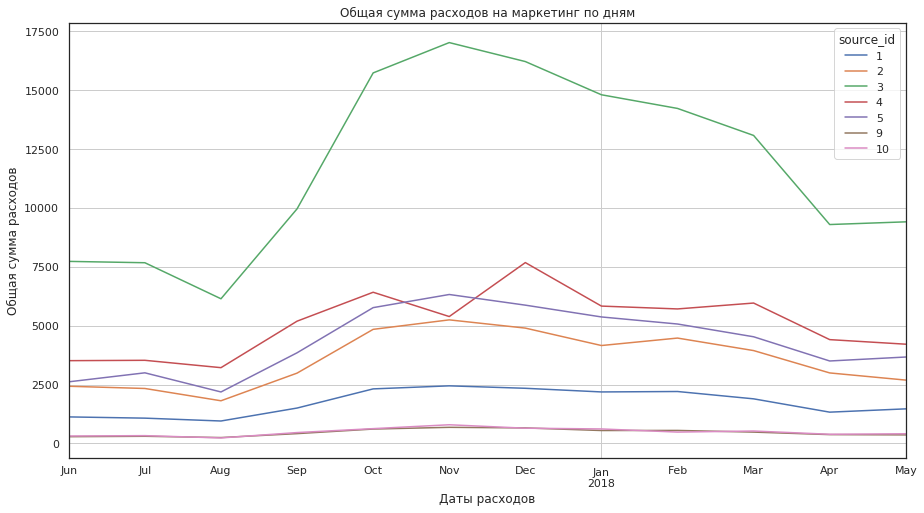

In [ ]:
costs['month'] = costs['dt'].astype('datetime64[M]')
costs.pivot_table(index='month', columns='source_id', values='costs', aggfunc='sum').plot(figsize = (15,8), grid=True)
plt.title('Общая сумма расходов на маркетинг по месяцам')
plt.xlabel('Даты расходов')
plt.ylabel('Общая сумма расходов')
plt.show()

Графики расходов на маркетинг во времени похожи друг на друга, выделяется график маркетинговых расходов на источник 3: они резко повышаются с августа до апреля.

In [ ]:
costs['costs'].sum() / orders['uid'].nunique()

9.011626098622786

Средний CAC (=customer acquisition cost) на одного покупателя для всего проекта равняется 9 у.е.

### Рассчитаем стоимость привлечения пользователей по источникам во времени

In [ ]:
source_id = visits[['uid', 'start_ts', 'source_id']]
source_id.columns = ['uid', 'first_session', 'source_id']
source_id = pd.merge(left=first_session_order, right=source_id, how='inner', on=['uid', 'first_session'])
orders_with_sources = pd.merge(left=orders, right=source_id, how='inner', on='uid')
orders_with_sources['first_order_month'] = orders_with_sources['buy_ts'].astype('datetime64[M]')
orders_with_sources

,buy_ts,revenue,uid,first_order,first_session,source_id,first_order_month
0,2017-06-01 00:10:00,17.00,10329302124590727494,2017-06-01 00:10:00,2017-06-01 00:09:00,1,2017-06-01
1,2017-06-01 00:25:00,0.55,11627257723692907447,2017-06-01 00:25:00,2017-06-01 00:14:00,2,2017-06-01
2,2017-06-01 00:27:00,0.37,17903680561304213844,2017-06-01 00:27:00,2017-06-01 00:25:00,2,2017-06-01
3,2017-06-01 00:29:00,0.55,16109239769442553005,2017-06-01 00:29:00,2017-06-01 00:14:00,2,2017-06-01
4,2017-06-01 07:58:00,0.37,14200605875248379450,2017-06-01 07:58:00,2017-06-01 07:31:00,3,2017-06-01
...,...,...,...,...,...,...,...
50410,2018-05-31 23:50:00,4.64,12296626599487328624,2018-05-31 23:50:00,2018-05-31 09:11:00,4,2018-05-01
50411,2018-05-31 23:50:00,5.80,11369640365507475976,2018-05-31 23:50:00,2018-05-31 23:05:00,10,2018-05-01
50412,2018-05-31 23:54:00,0.30,1786462140797698849,2018-05-31 23:54:00,2018-05-31 23:52:00,3,2018-05-01
50413,2018-05-31 23:56:00,3.67,3993697860786194247,2018-05-31 23:56:00,2017-10-23 12:32:00,3,2018-05-01


Получили таблицу, которая нам позже понадобится для расчета LTV и ROMI.

In [ ]:
costs['first_order_month'] = costs['dt'].astype('datetime64[M]')
costs_by_source_month = costs.groupby(['source_id', 'first_order_month'])['costs'].sum()
costs_by_source_month

source_id  first_order_month
1          2017-06-01           1125.61
           2017-07-01           1072.88
           2017-08-01            951.81
           2017-09-01           1502.01
           2017-10-01           2315.75
                                 ...   
10         2018-01-01            614.35
           2018-02-01            480.88
           2018-03-01            526.41
           2018-04-01            388.25
           2018-05-01            409.86
Name: costs, Length: 84, dtype: float64

Получили общую сумму маркетинговых расходов для каждой когорты.

In [ ]:
source_id['first_order_month'] = source_id['first_order'].astype('datetime64[M]')
source_id_month_users = source_id.groupby(['source_id', 'first_order_month'])['uid'].nunique()
source_id_month_users

source_id  first_order_month
1          2017-06-01           190
           2017-07-01           160
           2017-08-01           113
           2017-09-01           227
           2017-10-01           340
                               ... 
10         2018-01-01            92
           2018-02-01           123
           2018-03-01           186
           2018-04-01           107
           2018-05-01           130
Name: uid, Length: 86, dtype: int64

Получили общее количество привлеченных пользователей по месяцам в когорте.

In [ ]:
costs_by_source_month_n_users = pd.concat([source_id_month_users, costs_by_source_month], axis=1)
costs_by_source_month_n_users['cac'] = costs_by_source_month_n_users['costs'] / costs_by_source_month_n_users['uid']
costs_by_source_month_n_users = costs_by_source_month_n_users.reset_index()
costs_by_source_month_n_users

,source_id,first_order_month,uid,costs,cac
0,1,2017-06-01,190,1125.61,5.924263
1,1,2017-07-01,160,1072.88,6.705500
2,1,2017-08-01,113,951.81,8.423097
3,1,2017-09-01,227,1502.01,6.616784
4,1,2017-10-01,340,2315.75,6.811029
...,...,...,...,...,...
81,10,2018-01-01,92,614.35,6.677717
82,10,2018-02-01,123,480.88,3.909593
83,10,2018-03-01,186,526.41,2.830161
84,10,2018-04-01,107,388.25,3.628505


Получили таблицу, где есть все данные для расчета CAC по когортам во времени.

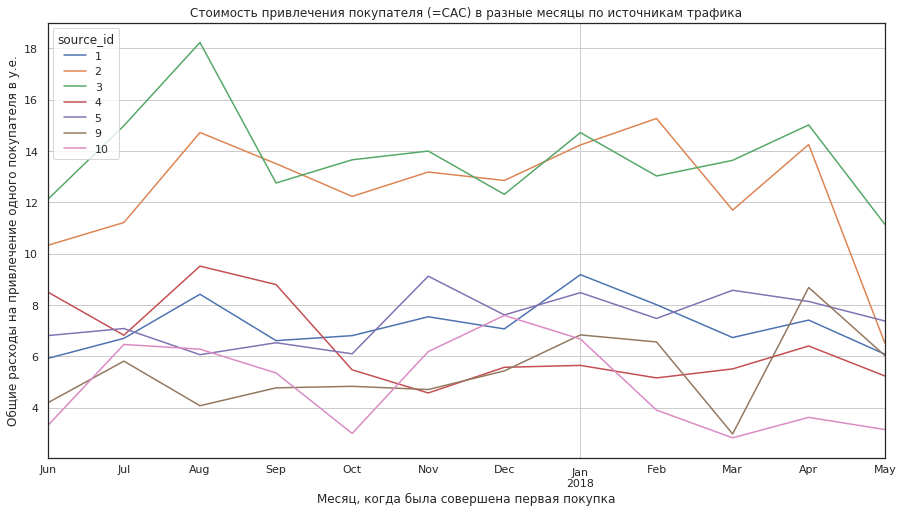

In [ ]:
costs_by_source_month_n_users.pivot_table(index='first_order_month', columns='source_id', values='cac', aggfunc='mean').plot(figsize = (15,8), grid=True)
plt.title('Стоимость привлечения покупателя (=CAC) в разные месяцы по источникам трафика')
plt.xlabel('Месяц, когда была совершена первая покупка')
plt.ylabel('Общие расходы на привлечение одного покупателя в у.е.')
plt.show()

С июня 2017 по май 2018 больше всего тратились на привлечение одного покупателя из источников 3 и 2.

### Рассчитаем ROMI по когортам в разрезе источников

In [ ]:
def calculate_romi_by_source(orders_df, source, cac):
    ltv_orders = orders_df[orders_df['source_id'] == source].copy()
    costs_by_source_month_n_users = cac[cac['source_id'] == source]
    ltv_orders['order_month'] = ltv_orders['buy_ts'].astype('datetime64[M]')
    ltv_first_orders = ltv_orders.groupby('uid').agg({'order_month': 'min'}).reset_index()
    ltv_first_orders.columns = ['uid', 'first_order_month']
    
    cohort_sizes = (
    ltv_first_orders.groupby('first_order_month')
    .agg({'uid': 'nunique'})
    .reset_index())
    cohort_sizes.columns = ['first_order_month', 'n_buyers']
    
    ltv_orders = pd.merge(ltv_orders, ltv_first_orders, on='uid')
    
    cohorts = (
    ltv_orders.groupby(['first_order_month', 'order_month'])
    .agg({'revenue': 'sum'})
    .reset_index())
    
    margin_rate = 1.0
    
    ltv_report = pd.merge(cohort_sizes, cohorts, on='first_order_month')

    ltv_report['gp'] = ltv_report['revenue'] * margin_rate
    ltv_report['age'] = (ltv_report['order_month'] - ltv_report['first_order_month']) / np.timedelta64(1, 'M')
    ltv_report['age'] = ltv_report['age'].round().astype('int')
    
    ltv_report['ltv'] = ltv_report['gp'] / ltv_report['n_buyers']
    
    ltv_report = ltv_report.merge(costs_by_source_month_n_users[['first_order_month', 'cac']], on='first_order_month')
    ltv_report['romi'] = ltv_report['ltv'] / ltv_report['cac']
    
    output = ltv_report.pivot_table(
    index='first_order_month', columns='age', values='romi', aggfunc='mean'
)
    
    
    return output.cumsum(axis=1)

Функция рассчитывает ROMI по двум таблицам: доходам с источником трафика и таблице с cac. Еще нужно указать номер источника, для которого будет рассчитываться ROMI. Таблицы взяты из предыдущих разделов этого отчета, механика расчета LTV - из раздела 4.4.


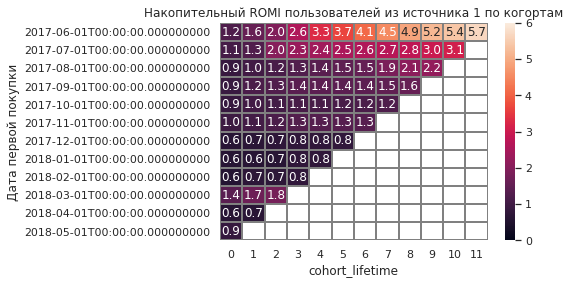

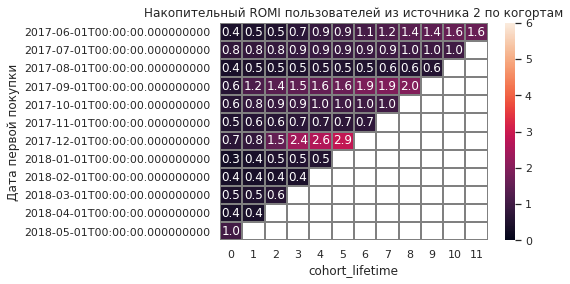

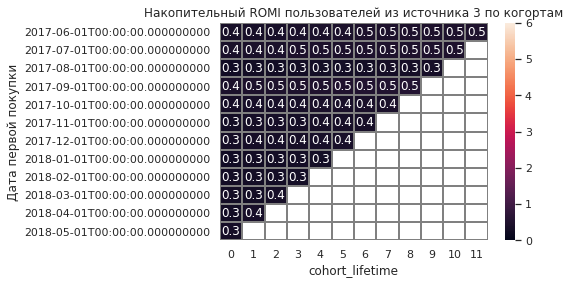

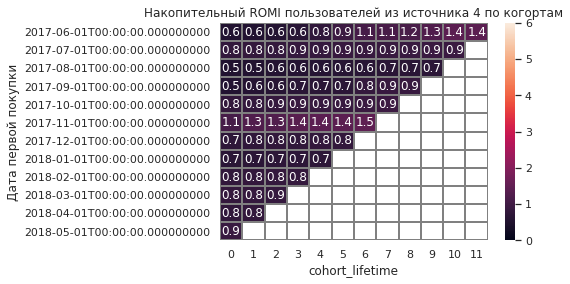

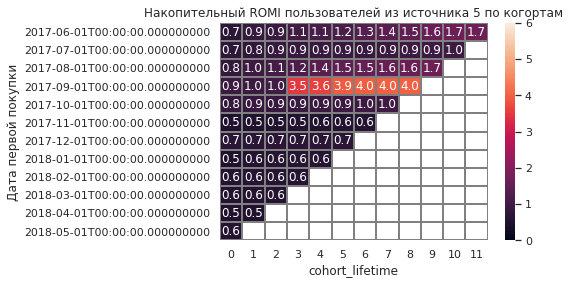

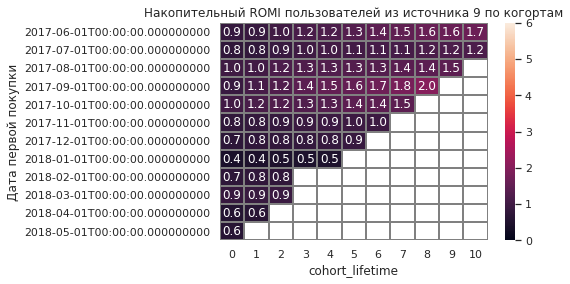

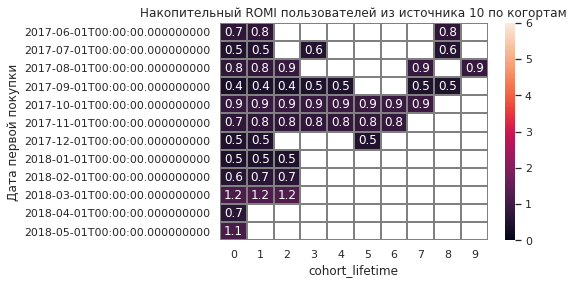

In [ ]:
for i in [1,2,3,4,5,9,10]:
        sns.heatmap(calculate_romi_by_source(orders_with_sources[['buy_ts', 'revenue', 'uid', 'source_id']], i, costs_by_source_month_n_users), 
                    annot=True, fmt='.1f', linewidths=1, linecolor='gray', vmin = 0, vmax = 6)
        plt.title(f'Накопительный ROMI пользователей из источника {i} по когортам')
        plt.xlabel('cohort_lifetime')
        plt.ylabel('Дата первой покупки')
        plt.title(f'Накопительный ROMI пользователей из источника {i} по когортам')
        plt.xlabel('cohort_lifetime')
        plt.ylabel('Дата первой покупки')
        plt.show()

Самый низкий ROMI у источников 3 и 10. Почти ни одна когорта из этих источников не окупилась. Самый высокий - у источника 1. Аномально высокие результаты у когорты 06.2017, 07.2017 у источника 1 и 09.2017 у источника 5.

### Выводы:

* Средний CAC (=customer acquisition cost) на одного покупателя для всего проекта равняется 9 у.е.
* Мы видим, что больше всего денег потратили на рекламу из источника 3, меньше всего - из источников 9 и 10
* С июня 2017 по май 2018 больше всего тратились на привлечение одного покупателя из источников 3 и 2
* Самый низкий ROMI у источников 3 и 10. Почти ни одна когорта из этих источников не окупилась. Самый высокий - у источника 1. Аномально высокие результаты у когорты 06.2017, 07.2017 у источника 1 и 09.2017 у источника 5

## Рекомендации:
    

* Стоит отказаться от закупки рекламы из источника 10 - за анализируемый период на трафик из этого источника потрачено больше всего денег, но ROMI трафика из этого источника - наименьший, ни в одной когорте пользователей он доходит до максимум 0.5.
* Под вопросом трафик из источника 4 - по общему количеству потраченных средств он уступает только трафику из источника 10, но ROMI 3/4 когорт к 6-му месяцу не достигает 1.
* Нужно увеличить расходы на рекламу из источника 1 и 4 - ROMI самый высокий среди всех источников трафика, на 6-й месяц окупились пользователи всех когорт.
* Следует обратить внимание на аномально высокие результаты у когорты 06.2017, 07.2017 у источника 1 и 09.2017 у источника 5.

## Общие выводы и наблюдения по итогам работы с данными:

* В среднем пользователи проводят около 5 минут на сайте

* Чаще всего на сайт заходят с октября по март, пиковые значения пользовательской активности приходятся на конец ноября

* В среднем пользователи, которые зашли на сайт, в тот же день больше на него не возвращаются (среднее арифметическое - 1.08 заходов в день)

* Средний Retention Rate равен 5%

* Retention Rate колеблется в районе 2-5%. Нельзя сказать, что он постоянно снижается: часто retention выше на более поздних месяцах жизни когорты

* Средний LTV за 6 месяцев по когортам равен 7.9 у.е., тогда как средний CAC - равняется 9 у.е. В среднем пользователи за 6 месяцев не окупаются

* Самый низкий ROMI у источников 3 и 10. Почти ни одна когорта из этих источников не окупилась. Самый высокий - у источника 1. Аномально высокие результаты у когорты 06.2017, 07.2017 у источника 1 и 09.2017 у источника 5

* В среднем между первым заходом на сайт и покупкой прошло 16 минут. По всей видимости, пользователи в основном совершают покупки в первый же заход. Если не купил сразу - видимо, не купит и после.